# ANALYZE COMPANY'S SALES

In [111]:
# Load all the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
import datetime
import scipy.stats as sci
%matplotlib inline

In [2]:
transactions = pd.read_csv("datasets/transactions.csv")
customers = pd.read_csv("datasets/customers.csv")
products = pd.read_csv("datasets/products.csv")

In [3]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [6]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [7]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [9]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


## Cleaning all datasets

### Cleaning transactions dataset  
#### Define

- **Some date starting with test must be split**
- **Date variable must be a *datetime* not a string**  
- **We must split id_prod in category and id_prod**
- **We must split session_id in session id and session_category**
- **We must split client_id in client_id and client_category**
- **Turn all the categories variable into a category data type**

#### Code

In [10]:
# Write  a function to split a column
def split_columns(dataset, col):
    ### This function take a dataset and a column of the dataset split the column and return the 2 new columns
    new_col_1 = dataset[col].map(lambda x : x.split("_")[1])
    new_col_2 = dataset[col].map(lambda x : x.split("_")[0].upper())
    return new_col_1, new_col_2

In [11]:
# Create a copy of transactions dataset
transactions_clean = transactions.copy()

In [12]:
# Split id_prod in 2 columns,id_prod and category
transactions_clean["id_prod"], transactions_clean["category"] = split_columns(transactions_clean, "id_prod")

In [13]:
# Split client_id columns into 2 columns, client_id and client_category
transactions_clean["client_id"], transactions_clean["client_category"] = split_columns(transactions_clean, "client_id")

In [14]:
# Split session_id in 2 columns, session_id and sesseion_category
transactions_clean["session_id"], transactions_clean["session_category"] = split_columns(transactions_clean, "session_id")

In [15]:
# Check if everything is ok
transactions_clean.head()

,id_prod,date,session_id,client_id,category,client_category,session_category
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S
2,374,2021-09-23 15:13:46.938559,94290,4270,1,C,S
3,2186,2021-10-17 03:27:18.783634,105936,4597,0,C,S
4,1351,2021-07-17 20:34:25.800563,63642,1242,0,C,S


In [16]:
# Check the different categories
transactions_clean.query("category == 'T'")

,id_prod,date,session_id,client_id,category,client_category,session_category
1431,0,test_2021-03-01 02:30:02.237420,0,1,T,CT,S
2365,0,test_2021-03-01 02:30:02.237446,0,1,T,CT,S
2895,0,test_2021-03-01 02:30:02.237414,0,1,T,CT,S
5955,0,test_2021-03-01 02:30:02.237441,0,0,T,CT,S
7283,0,test_2021-03-01 02:30:02.237434,0,1,T,CT,S
...,...,...,...,...,...,...,...
332594,0,test_2021-03-01 02:30:02.237445,0,0,T,CT,S
332705,0,test_2021-03-01 02:30:02.237423,0,1,T,CT,S
332730,0,test_2021-03-01 02:30:02.237421,0,1,T,CT,S
333442,0,test_2021-03-01 02:30:02.237431,0,1,T,CT,S


There are 200 rows which date starts with test. We can guess that it was just to *test* if the system is working or not. These rows are not useful for our analysis. We will remove them.
We can therefore notice that the test day was on 2021-03-01 at 02:30:02 am.

In [17]:
# Remove all the test dates
transactions_clean = transactions_clean.query("category != 'T'")

In [18]:
# Check if there are still test date, no output means there is no test date anymore
assert transactions_clean.category.all() != "T"

In [19]:
transactions_clean.date = transactions_clean.date.astype("datetime64")

In [20]:
# Assert that the date is in the correct type
transactions_clean.date.head()

0   2021-04-10 18:37:28.723910
1   2022-02-03 01:55:53.276402
2   2021-09-23 15:13:46.938559
3   2021-10-17 03:27:18.783634
4   2021-07-17 20:34:25.800563
Name: date, dtype: datetime64[ns]

In [21]:
# turn all the categories variable into a category data type
transactions_clean.iloc[:, 4:] = transactions_clean.iloc[:, 4:].astype("category")

In [22]:
# Check if the variables are categories
transactions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 337015
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id_prod           336816 non-null  object        
 1   date              336816 non-null  datetime64[ns]
 2   session_id        336816 non-null  object        
 3   client_id         336816 non-null  object        
 4   category          336816 non-null  category      
 5   client_category   336816 non-null  category      
 6   session_category  336816 non-null  category      
dtypes: category(3), datetime64[ns](1), object(3)
memory usage: 13.8+ MB


### Cleaning customers dataset  
#### Define  
- **Split client_id variable into 2 variables**
- **Turn sex variabble in uppercase**
- **Turn sex variable into category data type**

In [23]:
# Make a copy of customers dataset
customers_clean = customers.copy()

In [24]:
# Spllit client_id
customers_clean["client_id"], customers_clean["client_category"] = split_columns(customers_clean, "client_id")

In [25]:
# Turn sex in uppercase
customers_clean.sex = customers_clean.sex.map(lambda x : x.upper())

In [26]:
# Turn sex into category
customers_clean.sex = customers_clean.sex.astype("category")

In [27]:
# Check the final dataset
print(customers_clean.head())
print("=========================================")
customers_clean.info()

  client_id sex  birth client_category
0      4410   F   1967               C
1      7839   F   1975               C
2      1699   F   1984               C
3      5961   F   1962               C
4      5320   M   1943               C
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   client_id        8623 non-null   object  
 1   sex              8623 non-null   category
 2   birth            8623 non-null   int64   
 3   client_category  8623 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 210.7+ KB


### Cleaning products dataset  
#### Define  
- **Categ variable must be category type not an int**
- **Change the categ name to category**  
- **Split the id_prod and keep just the id products**  
- **There is a price of -1, we will remove it**

In [28]:
# Make a copy of the products dataset
products_clean = products.copy()

In [29]:
# Change the categ name to category
products_clean = products_clean.rename(columns={"categ":"category"})

In [30]:
# Split id_prod and keep just the id products using the split_columns function
products_clean["id_prod"], products_clean["category"] = split_columns(products_clean, "id_prod")

In [31]:
# Turn the category into a category type
products_clean.category = products_clean.category.astype("category")

In [32]:
# Check if everything is correct
products_clean.head(2)

,id_prod,price,category
0,1421,19.99,0
1,1368,5.13,0


In [33]:
products_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_prod   3287 non-null   object  
 1   price     3287 non-null   float64 
 2   category  3287 non-null   category
dtypes: category(1), float64(1), object(1)
memory usage: 54.9+ KB


In [34]:
# Check the -1 price row
products_clean.query("price == -1")

,id_prod,price,category
731,0,-1.0,T


This is probably another test, we will remove it for a better analysis.

In [35]:
products_clean = products_clean.query("price != -1")

In [36]:
# Check the description to see if it is ok
products_clean.describe()

,price
count,3286.000000
mean,21.863597
std,29.849786
min,0.620000
25%,6.990000
50%,13.075000
75%,22.990000
max,300.000000


Now that all the datasets are clean we can join them all together in a unique dataset for anaylysis.

In [37]:
# Join all the datasets together
sales_merge = transactions_clean.merge(products_clean, on = ["category", "id_prod"], how = "left")

In [38]:
sales_df = sales_merge.merge(customers_clean, on = ["client_id", "client_category"], how = "left")

In [39]:
# Turn category and client category into categorical variable
sales_df.iloc[:, 4:6] = sales_df.iloc[:, 4:6].astype("category")
# Check if it is ok
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 336815
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id_prod           336816 non-null  object        
 1   date              336816 non-null  datetime64[ns]
 2   session_id        336816 non-null  object        
 3   client_id         336816 non-null  object        
 4   category          336816 non-null  category      
 5   client_category   336816 non-null  category      
 6   session_category  336816 non-null  category      
 7   price             336713 non-null  float64       
 8   sex               336816 non-null  category      
 9   birth             336816 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 19.3+ MB


In [40]:
# Create the variable age, today date - birth date
sales_df["age"] = datetime.datetime.now().year - sales_df.birth # Can lead to error if data is not updated over time
sales_df.head(2)

,id_prod,date,session_id,client_id,category,client_category,session_category,price,sex,birth,age
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S,4.99,F,1977,43
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S,65.75,F,2000,20


In [41]:
# Remove the useless column birth
clean_df = sales_df.drop("birth", axis = 1)
clean_df.head(2)

,id_prod,date,session_id,client_id,category,client_category,session_category,price,sex,age
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S,4.99,F,43
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S,65.75,F,20


## ANALYZE THE DATA  

Now that all the datasets are cleaned we can make some analysis. 


**What is the average price of the sales?**

In [42]:
clean_df.describe()

,price,age
count,336713.000000,336816.000000
mean,17.215189,42.176604
std,17.855445,13.523923
min,0.620000,16.000000
25%,8.610000,33.000000
50%,13.900000,40.000000
75%,18.990000,49.000000
max,300.000000,91.000000


We have an average price of **17.22** but with a standard deviation of **17.85** which means that there are too much variability between the prices. Let's go deep with some plots.  

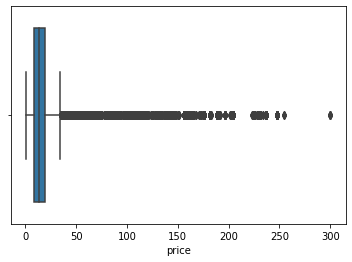

In [43]:
# Boxplot to see the variability
sb.boxplot(clean_df.price);

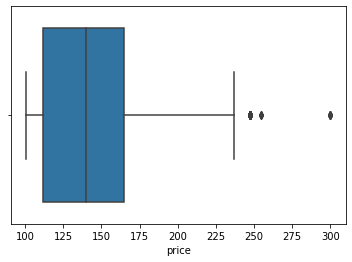

In [44]:
clean_df_30 = clean_df.price[clean_df.price > 100]
sb.boxplot(clean_df_30);

In [45]:
clean_df_30.median()

139.99

Most of the sales are between 0 and 20 and there are very few sales between 50 and 300. 
The average price value of 17.22 is just due to the fact that there are few high sales. Let's confirm that with some calculations.  

In [46]:
print("mean : ",clean_df.price.mean())
print("median : ",clean_df.price.median())
print("mode : ",clean_df.price.mode()[0])

mean :  17.215188513733644
median :  13.9
mode :  15.99


We confirm here that most of the sales are between **0 and 16**, with highest sales at **13.9**

**Which are the categories with more sales?**

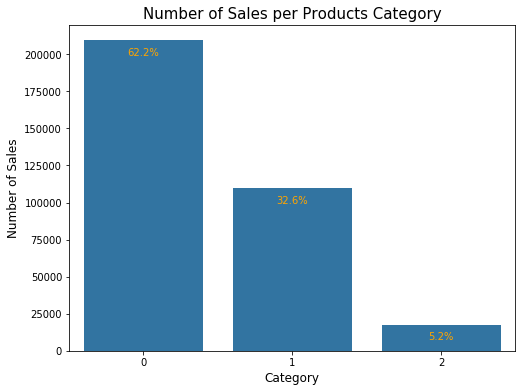

In [47]:
plt.figure(figsize = [8,6])
# Choose a standard color for the plot
base_color = sb.color_palette()[0]
# Barplot of the categories
sb.countplot(data = clean_df, x = "category", color = base_color)
plt.title("Number of Sales per Products Category", fontsize = 15)
plt.xlabel(xlabel = "Category", fontsize = 12)
plt.ylabel(ylabel = "Number of Sales", fontsize = 12)
# Add some annotations
number_points = clean_df.shape[0]        # number of points in the dataset
category_counts = clean_df.category.value_counts() # all Values of the categories
locs, labels = plt.xticks()   # Current tick locations and labels
# Loop through each pair of locations and labels  
for loc, label in zip(locs, labels):
    # Text property for the label to get the current count
    count = category_counts[label.get_text()]
    percentage = '{:0.1f}%'.format(100*count/number_points) # Percentage of each category
    # Put the annotations inside the bar on the top
    plt.text(x = loc, y = count-10000, s = percentage, ha = 'center', color = 'orange')

**62%** of the sales are in category 0, **33%** in category 1 and just **5.2%** in category 2. 

**What is the Average sale in each category?**

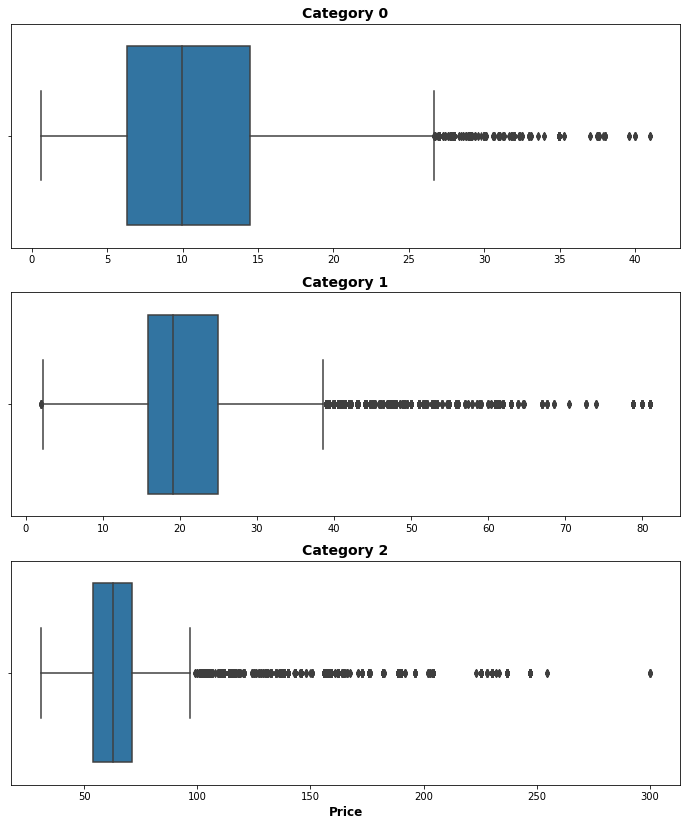

In [48]:
plt.figure(figsize = [12,14])
plt.subplot(3,1,1)
sb.boxplot(data = clean_df[clean_df.category == "0"], x = "price")
plt.title("Category 0", fontsize = 14, fontweight = "bold")
plt.xlabel("")

plt.subplot(3,1,2)
sb.boxplot(data = clean_df[clean_df.category == "1"], x = "price")
plt.title("Category 1", fontsize = 14, fontweight = "bold")
plt.xlabel("")

plt.subplot(3,1,3)
sb.boxplot(data = clean_df[clean_df.category == "2"], x = "price")
plt.title("Category 2", fontsize = 14, fontweight = "bold")
plt.xlabel("Price", fontsize = 12, fontweight = "bold");

In [49]:
for i in range(3):
    print("Mean Category " + str(i) + ": ", clean_df.price[clean_df.category == str(i)].mean())
    print("Median Category " + str(i) + ": ", clean_df.price[clean_df.category == str(i)].median())
    print("Mode Category " + str(i) + ": ", clean_df.price[clean_df.category == str(i)].mode()[0])
    print("Standard Deviation Category " + str(i) + ":", clean_df.price[sales_merge.category == str(i)].std(),"\n")    

Mean Category 0:  10.646828235274288
Median Category 0:  9.99
Mode Category 0:  4.99
Standard Deviation Category 0: 4.930029770963229 

Mean Category 1:  20.4801058003428
Median Category 1:  19.08
Mode Category 1:  15.99
Standard Deviation Category 1: 7.568956079961025 

Mean Category 2:  75.17494929352519
Median Category 2:  62.83
Mode Category 2:  68.99
Standard Deviation Category 2: 39.0799988187327 



**Distribution of sales by birth**

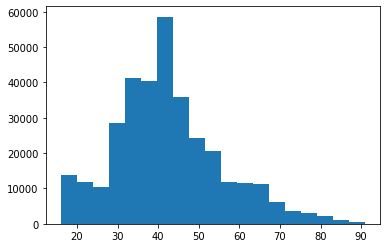

In [50]:
bin_num = int(1 + np.log2(clean_df.shape[0]))
plt.hist(clean_df.age, bins = bin_num);

Most of the sales come from people aged between 30 and 55 with a peak at 40 years old.

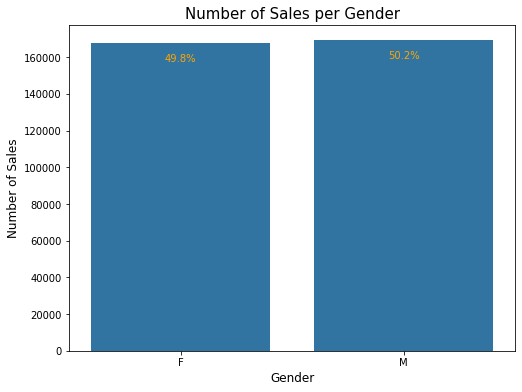

In [51]:
plt.figure(figsize = [8,6])
# Choose a standard color for the plot
base_color = sb.color_palette()[0]
# Barplot of the categories
sb.countplot(data = clean_df, x = "sex", color = base_color)
plt.title("Number of Sales per Gender", fontsize = 15)
plt.xlabel(xlabel = "Gender", fontsize = 12)
plt.ylabel(ylabel = "Number of Sales", fontsize = 12)
# Add some annotations
number_points = clean_df.shape[0]        # number of points in the dataset
category_counts = clean_df.sex.value_counts() # all Values of the categories
locs, labels = plt.xticks()   # Current tick locations and labels
# Loop through each pair of locations and labels  
for loc, label in zip(locs, labels):
    # Text property for the label to get the current count
    count = category_counts[label.get_text()]
    percentage = '{:0.1f}%'.format(100*count/number_points) # Percentage of each category
    # Put the annotations inside the bar on the top
    plt.text(x = loc, y = count-10000, s = percentage, ha = 'center', color = 'orange')

There is no big difference in sales between gender

**Correlations**

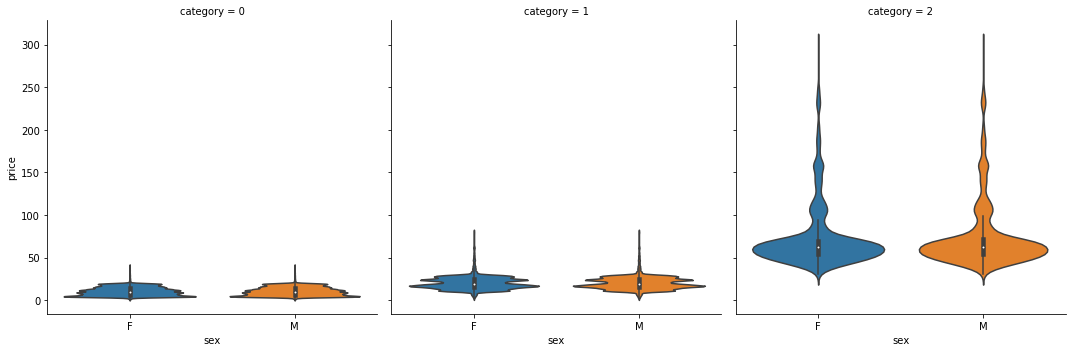

In [58]:
# Correlation between gender and categories of products purchased
sb.catplot(x = "sex", y = "price", col = "category", kind = "violin" ,split = True, data = clean_df);

In [128]:
# Contigency table
gender_category_table = pd.crosstab(index = clean_df.category, columns = clean_df.sex)
gender_category_table

sex,F,M
category,,
0,103846,105683
1,55469,54266
2,8260,9292


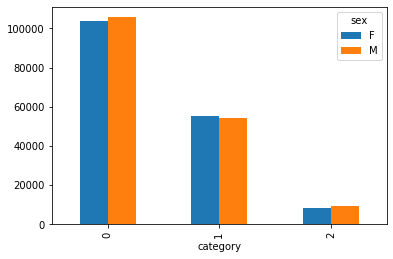

In [132]:
gender_category_table.plot(kind="bar");

In [138]:
stat, p, dof, expected = sci.chi2_contingency(gender_category_table)
if p > 0.05:
    print("Gender and Category are probably independent")
else:
    print("Gender and Category are probably dependent")

Gender and Category are probably dependent


**Correlation between age and total amount of purchases**

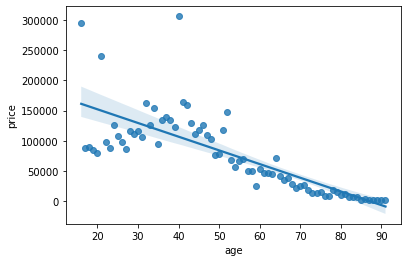

In [120]:
# Create a dataframe with age and the total amount purchases
corr_age_price = clean_df.groupby("age").sum().reset_index()
# Plot using regplot
sb.regplot(x = "age", y = "price", data = corr_age_price, fit_reg = True);

There is correlation between the age and the amount of purchases, as the age increases the amount of purchases decreases.

**Correlation between age and the purchase frequency(Number of purchases per month)**

In [92]:
clean_df.head()

,id_prod,date,session_id,client_id,category,client_category,session_category,price,sex,age,month
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S,4.99,F,43,4
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S,65.75,F,20,2
2,374,2021-09-23 15:13:46.938559,94290,4270,1,C,S,10.71,F,41,9
3,2186,2021-10-17 03:27:18.783634,105936,4597,0,C,S,4.20,M,57,10
4,1351,2021-07-17 20:34:25.800563,63642,1242,0,C,S,8.99,F,40,7
